In [68]:
import os 
import io
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap
import json

In [69]:
INVENTORY, POLLUTION, BAY, PARKS, WALKS, SCHOOLS, MATCHES = None, None, None, None, None, None, None
PARENT_DIR = os.getcwd()

In [70]:
def get_schools():
    global SCHOOLS
    if SCHOOLS is None:
        schools = gpd.read_file(
            PARENT_DIR + "/data/California_School_District_Areas_2017-18-shp/DistrictAreas1718.shp"
        )
        SCHOOLS = schools.to_crs(epsg=3857)
    return SCHOOLS

In [71]:
def get_sites():
    global INVENTORY
    if INVENTORY is None:
        inventory = gpd.read_file(
            PARENT_DIR + "/data/housing_sites/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp"
        )
        INVENTORY = inventory.to_crs(epsg=3857)
    return INVENTORY

In [72]:
def get_parks():
    global PARKS
    if PARKS is None:
        parks = gpd.read_file(
            PARENT_DIR + "/data/CFF_SPP_Round4_Data/CFF_Update_2021_04_30/parks_final_2021_04_30.shp"
        )
        PARKS = parks.to_crs(epsg=3857)
    return PARKS

In [73]:
def get_walk_scores():
    global WALKS
    if WALKS is None:
        walks = pd.read_csv(
            PARENT_DIR + "/data/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv"
        )
        WALKS=walks
    return WALKS

In [74]:
def get_matches():
    global MATCHES
    if MATCHES is None:
        with open(PARENT_DIR + '/data/matches.json', 'rb') as f:
            matches = json.load(f)
            MATCHES=matches
    return MATCHES

In [75]:
def get_matches_for(city):
    return get_matches()[city]

In [76]:
def sites_with_development_indicator(city):
    matches = get_matches_for(city)
    sites = get_5th_cycle_sites_for(city)
    sites['permitted'] = sites.index.isin(matches)
    return sites

In [77]:
def get_elementary_schools_for(city):
    schools = get_schools()
    elementary_schools = schools[schools.DistrictNa.str.contains('Elementary')]
    city_limits = get_city_limits(city)
    result = gpd.overlay(city_limits, elementary_schools, how='intersection', keep_geom_type=False)
    return result

In [78]:
def get_pollution_map():
    global POLLUTION
    if POLLUTION is None:
        pollution = gpd.read_file(
            './data/CalEnviroScreen_4.0Shapefile_D1_2021.shp'
        )
        POLLUTION = pollution.to_crs(epsg=3857)
    return POLLUTION

In [79]:
def get_bay_map():
    global BAY
    if BAY is None:
        bay = gpd.read_file(
            './data/bay_area_map/bay.shp'
        )
        bay['city'] = bay['city'].str.title()
        bay['county'] = bay['county'].str.title()
        BAY = bay.to_crs(epsg=3857)
    return BAY

In [80]:
def get_city_limits(city):
    bay = get_bay_map()
    return bay.query(f'city == "{city}"').to_crs(epsg=3857)

In [81]:
def get_parks_for(city):
    return get_parks().query(f'city == "{city}"')

In [82]:
def get_sites_for(city):
    sites = get_sites().query(f'jurisdict == "{city}"')
    return clean_real_cap(city, sites)

In [83]:
def get_5th_cycle_sites_for(city):
    return get_sites_for(city).query('rhnacyc == "RHNA5"')

In [84]:
def get_4th_cycle_sites_for(city):
    return get_sites_for(city).query('rhnacyc == "RHNA4"')

In [85]:
def get_city_sites_for_cycle(city, cycle):
    assert cycle in [4, 5]
    if cycle == 4:
        return get_4th_cycle_sites_for(city)
    else:
        return get_5th_cycle_sites_for(city)

In [86]:
def get_cities():
    cities_sites = set(get_sites().jurisdict.unique())
    cities_mapped = set(get_bay_map().city.unique())
    cities = cities_sites.intersection(cities_mapped)
    cities = list(cities)
    cities.sort()
    return cities

In [87]:
def get_pollution_for(city):
    city_shape = get_bay_map().query(f'city == "{city}"')
    city_shape = city_shape[['city', 'geometry']]
    result = gpd.overlay(city_shape, get_pollution_map(), how='intersection', keep_geom_type=False)
    if result.size:
        return result
    return

In [88]:
"""Code lifted from project here: https://github.com/YIMBYdata/housing-elements/blob/main/housing_elements/data_loading_utils.py"""

def clean_real_cap(city, sites):
    sites = sites.copy()
    if city in ('Oakland', 'Los Altos Hills', 'Napa County', 'Newark'):
        sites = remove_range_in_realcap(sites)
    if city in ('Danville', 'San Ramon', 'Corte Madera', 'Portola Valley'):
        sites = remove_units_in_realcap(sites)
    if city == 'El Cerrito':
        sites = fix_el_cerrito_realcap(sites)
    sites['relcapcty'] = pd.to_numeric(sites['relcapcty'], errors='coerce')
    sites = sites.rename({'relcapcty': 'realcap'}, axis=1)
    return sites

def remove_range_in_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    # E.g. Oakland, Newark
    sites.relcapcty = sites.relcapcty.str.split('-').str[-1]
    # Los Altos Hills
    sites.relcapcty = sites.relcapcty.str.split(' to ').str[-1]
    return sites

def remove_units_in_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    # San Ramon
    sites.relcapcty = sites.relcapcty.str.replace('á', '', regex=False)
    # Danville
    sites.relcapcty = sites.relcapcty.str.replace('sfr', '', regex=False)
    sites.relcapcty = sites.relcapcty.str.replace('SFR', '', regex=False)
    sites.relcapcty = sites.relcapcty.str.replace('mfr', '', regex=False)
    # Danville, Corte Madera, Portola Valley
    sites.relcapcty = sites.relcapcty.str.split(' ').str[0]
    return sites

def fix_el_cerrito_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    """El Cerrito's realcap is in plain english, listing primary units and accessory units."""
    el_cerrito_rc = []
    for v in sites.relcapcty.values:
        # If realcap includes primary and accessory units
        if isinstance(v, str) and 'primary and' in v:
            # Then let realcap equal double the # of primary units (which is always true)
            v = int(v.split(' ')[0]) * 2
        el_cerrito_rc.append(v)
    sites.relcapcty = el_cerrito_rc
    sites.relcapcty = sites.relcapcty.str.split(' ').str[0]
    return sites

To do: Check that geometry changes after intsection for at least one of the cities that pop up in print_pollution_map_city_incorrect()

In [89]:
def print_pollution_map_city_incorrect():
    """This function shows that census tracts extend beyond a single city."""
    for city in get_cities():
        n_tracts_trivial = sum(get_pollution_map().City == city)
        n_tracts_nontrivial = get_tracts(city).shape[0]
        if n_tracts_trivial != n_tracts_nontrivial:
            print(city, n_tracts_nontrivial - n_tracts_trivial)

In [90]:
def get_production_by_tract(tracts, sites):
    joined = gpd.tools.sjoin(tracts, sites)
    production_by_tract = joined.groupby('Tract').agg({'realcap': sum})
    return production_by_tract

In [91]:
def get_5th_cycle_tracts(city):
    sites = get_5th_cycle_sites_for(city)
    pollution = get_pollution_for(city)
    sites_by_tract = get_production_by_tract(pollution, sites)
    tracts = pollution.set_index('Tract')
    tracts['realcap'] = 0
    tracts.loc[sites_by_tract.index, 'realcap'] = sites_by_tract['realcap']
    tracts['acres'] = tracts['geometry'].to_crs(5070).geometry.area / 10**6 * 247
    tracts['homes per acre'] = tracts['realcap'] / tracts['acres']
    return tracts

In [92]:
def score_correlation(city, cycle):
    assert cycle in [4, 5]
    if cycle == 4:
        tracts = get_4th_cycle_tracts(city)
    else:
        tracts = get_5th_cycle_tracts(city)
    return pearsonr(tracts['homes per acre'], tracts['CIscoreP'])

In [93]:
def get_pastel_cmap():
    return LinearSegmentedColormap.from_list('pastel', [('#9EFF9E'), ('#ff6961')])

In [94]:
def plot_sites_on_top_of_arbitrary_map(city, cycle, df, variable, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 15))
    plt.rcParams.update({'font.size': 25})
    df.plot(ax=ax, column=df[variable], legend=True, cmap=get_pastel_cmap())
    plt.title(variable)
    plt.rcParams.update({'font.size': 10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    sites = get_city_sites_for_cycle(city, cycle)
    sites.centroid.plot(ax=ax, marker='o', markersize=sites['realcap'], color='steelblue')

In [95]:
def plot_sites_on_top_of_arbitrary_city_map(city, cycle, df, variable):
    fig, ax = plt.subplots(figsize=(15, 15))
    city_limits = get_city_limits(city)
    city_limits.plot(color='beige', ax=ax)
    plot_sites_on_top_of_arbitrary_map(city, cycle, df, variable, ax)

In [96]:
def plot_sites_on_top_of_schools(city, cycle, variable):
    schools = get_elementary_schools_for(city)
    plot_sites_on_top_of_arbitrary_city_map(city, cycle, schools, variable)

In [97]:
def plot_sites_on_top_of_arbitrary_enviro_map(city, cycle, variable):
    pollution = get_pollution_for(city)
    plot_sites_on_top_of_arbitrary_map(city, cycle, pollution, variable)

In [98]:
def plot_sites_and_parks(city, cycle):
    parks = get_parks_for(city)
    sites = get_city_sites_for_cycle(city, cycle)
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.rcParams.update({'font.size': 25})
    plt.title(f'Parks in {city}')
    sites.plot(ax=ax, color='steelblue')
    parks.plot(ax=ax, color='green')
    ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

In [99]:
def plot_sites_on_top_of_pollution_map(city, cycle):
    plot_sites_on_top_of_arbitrary_enviro_map(city, cycle, 'CIscoreP')

def plot_sites_on_top_of_diesel_particulate_map(city, cycle):
    plot_sites_on_top_of_arbitrary_enviro_map(city, cycle, 'Diesel_PM')
    
def plot_sites_on_top_of_lead_map(city, cycle):
    plot_sites_on_top_of_arbitrary_enviro_map(city, cycle, 'Lead_Pctl')
    
def plot_sites_on_top_of_hazardous_waste_map(city, cycle):
    plot_sites_on_top_of_arbitrary_enviro_map(city, cycle, 'Haz_Waste_')
    
def plot_sites_on_top_of_traffic_map(city, cycle):
    plot_sites_on_top_of_arbitrary_enviro_map(city, cycle, 'Traffic')

In [100]:
def plot_sites_walkability(city, cycle):
    plot_sites_on_top_of_arbitrary_map(city, cycle, pollution, variable)

In [ ]:
score_correlation('Mountain View', 5)

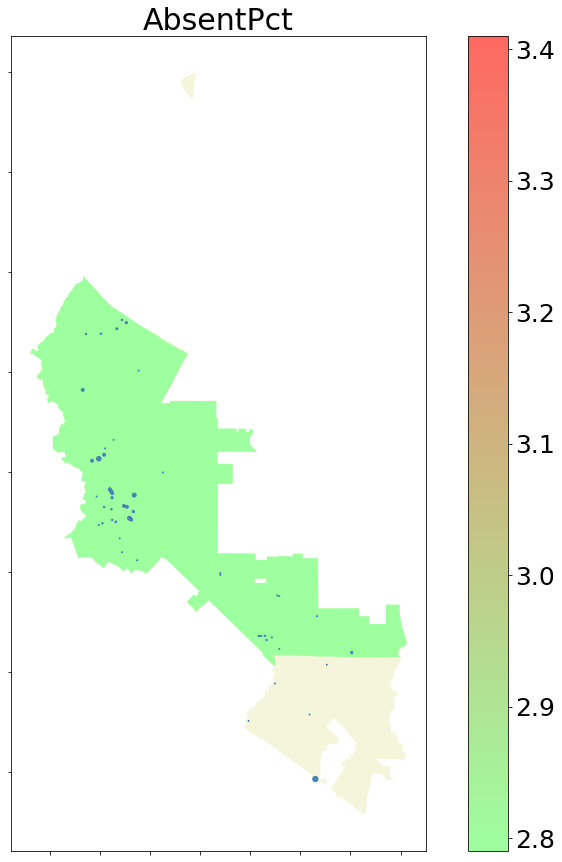

In [101]:
plot_sites_on_top_of_schools('Los Altos', 5, 'AbsentPct')

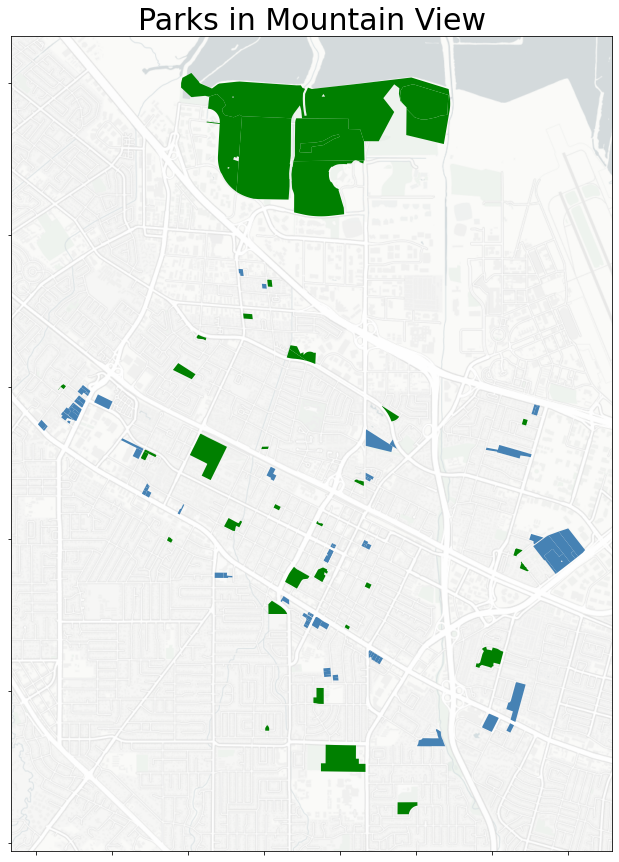

In [113]:
plot_sites_and_parks('Mountain View', 5)

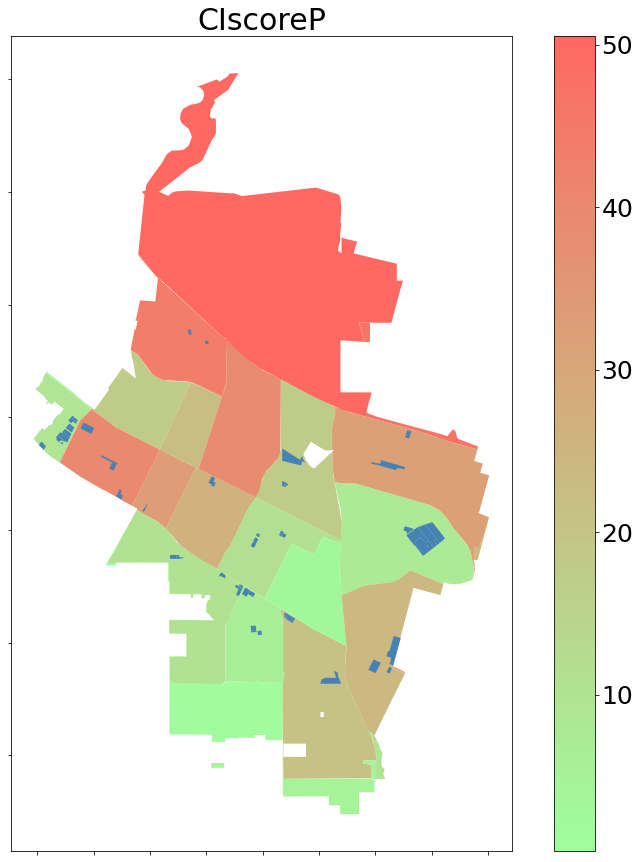

In [116]:
plot_sites_on_top_of_pollution_map('Mountain View', 5)

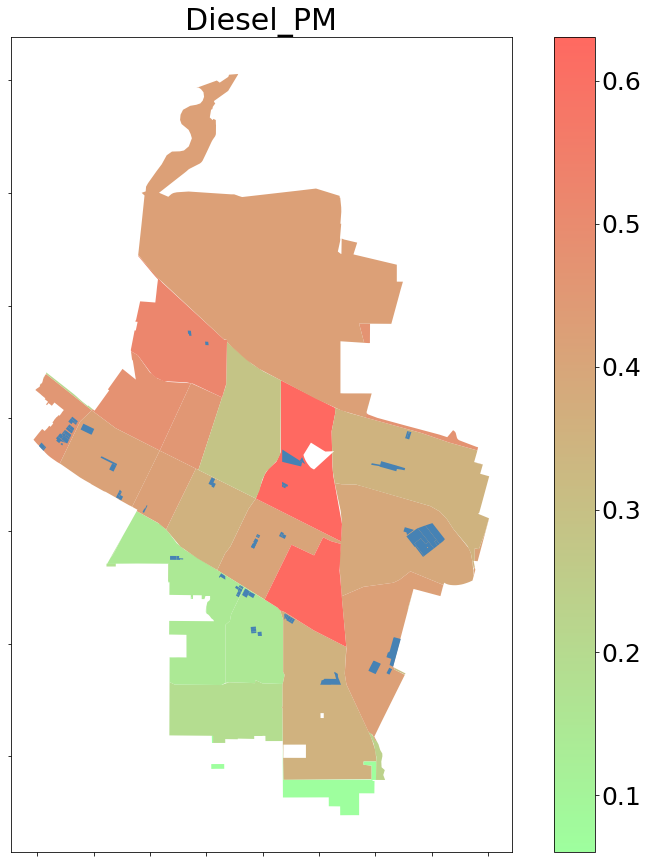

In [58]:
plot_sites_on_top_of_diesel_particulate_map('Mountain View', 5)

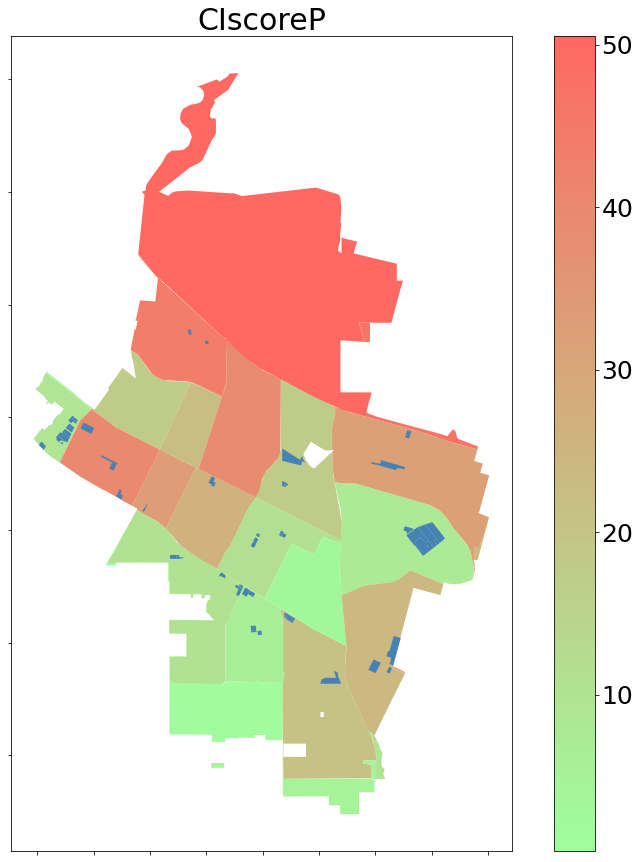

In [59]:
plot_sites_on_top_of_pollution_map('Mountain View', 5)

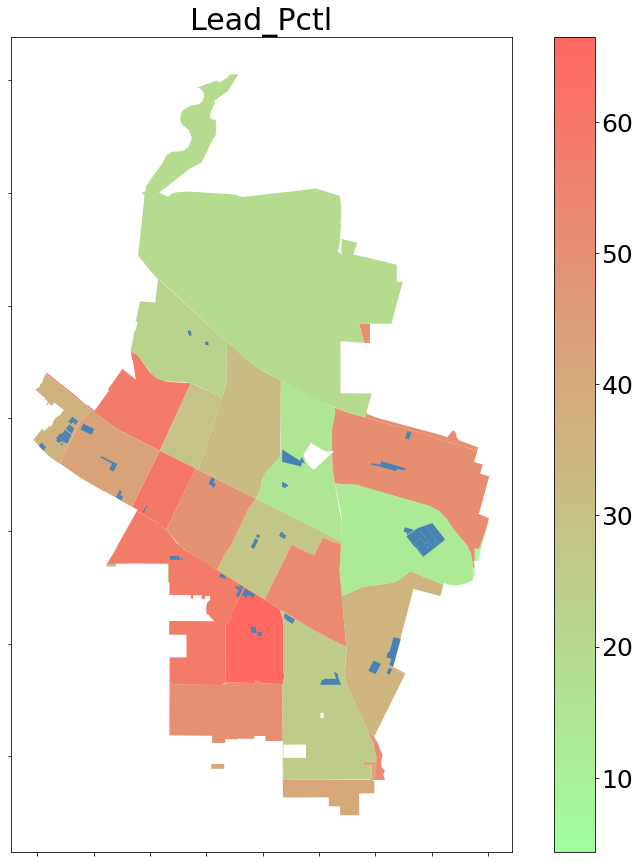

In [60]:
plot_sites_on_top_of_lead_map('Mountain View', 5)

In [34]:
get_5th_cycle_sites_for('San Francisco').columns

Index(['objectid', 'rhnacyc', 'rhnayrs', 'county', 'jurisdict', 'apn',
       'locapn', 'genplan', 'zoning', 'gacres', 'locacres', 'currunits',
       'allowden', 'allowlow', 'allowhigh', 'realcap', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_vl', 'num_l', 'num_m', 'num_am',
       'infcapcty', 'siteconst', 'sitetype', 'pdaparcel', 'bundled',
       'existuse', 'localnote', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

In [353]:
get_5th_cycle_sites_for('San Francisco').allowden.value_counts()

0               884
16.206051518      4
22.776500043      2
11.493562         2
20.424166484      2
               ... 
20.951187395      1
13.925551726      1
214.31905477      1
14.929365847      1
10.961940536      1
Name: allowden, Length: 3817, dtype: int64

In [ ]:
tracts_SF = get_5th_cycle_tracts('Mountain View')
plt.scatter(tracts_SF['homes per acre'], tracts_SF['CIscoreP'], s=tracts_SF['acres'], alpha=.4)
plt.xlabel("Homes per acre")
plt.ylabel("CIScoreP")
plt.title('Are more homes planned for areas with more pollution?')

In [ ]:
realcap_by_pctl = tracts_SF.groupby('Pctl_Range').agg({'realcap': sum})
realcap_by_pctl.sort_index(axis=0, key=lambda x: [int(v[0]) for v in x.str.split('-')], inplace=True)

In [ ]:
plt.barh(realcap_by_pctl.index, realcap_by_pctl.realcap)
plt.xlabel("Homes per acre")
plt.ylabel("Pollution")
plt.title("Is San Francisco building more homes in tracts with more pollution? It's unclear.")
plt.show()